In [13]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import itertools
from scipy.stats import spearmanr

from pathlib import Path

import os
import sys  

# set path for pixelator directory 
sys.path.insert(0, "/Users/janrkauert/pixelator/")

# load functions from pixelator
from pixelator.pixeldataset import PixelDataset
from pixelator.graph import Graph

# load standard workflow single cell functions
from colocalization_measures.plot import plot_mutliple_markers
from colocalization_measures.higher_order_similarity import calculate_higher_order_similarity
from colocalization_measures.adjusted_local_assortativity import calculate_adjusted_local_assorativity
from colocalization_measures.colocalization_scores import create_colocalization_scores

# get directory with graph eval files
path_name = "C:/Users/janrh/Downloads/Pixelator_data"

In [14]:
# new graph for all data
sample_list = []
pxl_data_list = []

for index_place, file in enumerate(sorted(os.listdir(path_name))):
    
    # get name of current file in directory
    filename = os.fsdecode(file)

    # load marker edge list
    pxl_data = PixelDataset.from_file(path_name + "/" + filename)
    edge_list_df = pxl_data.edgelist   

    edge_list_df.columns = [col.lower() for col in edge_list_df.columns]

    # build the graph
    graph = Graph.from_edgelist(edgelist=edge_list_df,
                                add_marker_counts=True,
                                simplify=False,
                                use_full_bipartite=False)
    mega_graph = graph._raw
    
    # add filename as a vertex attribute
    mega_graph.es["sample"] = [filename] * mega_graph.ecount()

    sample_list.append(mega_graph)
    pxl_data_list.append(pxl_data)

    print(filename)

Edge list with no sequence found


Uropod_S1_001.dataset.pxl


Edge list with no sequence found


Uropod_S3_001.dataset.pxl


In [15]:
# select sample to work on
sample_index = 1

# subgraphs of the selected sample
graph_component_subgraphs = sample_list[sample_index].components().subgraphs()

# load edge list from pixelator dataset
df = pxl_data_list[sample_index].edgelist

# create dictionary form all pixel names for each component
dict_comp_A = dict(zip(df["upia"].values, df["component"].values))
dict_comp_B = dict(zip(df["upib"].values, df["component"].values))

# create a set for all UPIA and UPIB for fast assessments
set_comp_A_pixels = set(df["upia"].values)
set_comp_B_pixels = set(df["upib"].values)

In [16]:
# marker combinations from the MPX paper
combinations = ["CD162_CD50", "CD162_CD37", "CD37_CD50", "B2M_CD162", "CD26_CD29",
                "CD37_CD45RB", "CD162_CD45", "CD162_HLA-ABC", "CD162_CD18", "CD162_CD26",
                "CD18_CD50", "CD50_HLA-ABC", "CD26_CD50", "CD45_CD50", "CD18_CD26", 
                "CD18_CD37", "CD37_CD45", "B2M_CD50", "B2M_CD37", "CD37_HLA-ABC",
                "CD50_CD7", "CD50_CD86", "CD16_CD37", "CD37_CD52", "CD48_CD50", "CD29_HLA-ABC",
                "CD50_CD59", "CD44_CD59", "CD162_CD59", "CD37_CD59", "CD2_CD37", "CD37_CD3E",
                "CD2_CD50", "CD3E_CD50", "CD162_CD2", "CD162_CD3E", "CD50_CD43"]

new_combinations = []
for combi in combinations:

    # transform combinations into workable format
    marker_1, marker_2 = combi.split("_")
    new_combinations.append((marker_1, marker_2))

# select markers for later method
combinations = new_combinations

In [25]:
marker_names = list(set(sum(new_combinations, ())))
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S3"

# calculate pairwise colocalization scores
similarity_measure_df = create_colocalization_scores(marker_names, path_data, combinations)

In [26]:
smlr_df = similarity_measure_df.mean(axis=1)

# create new dataframe to store the abundance of the markers per component
df_abundance = pd.DataFrame()
df_abundance["markers"] = marker_names


for comp_index, component in enumerate(graph_component_subgraphs):

    list_abundace_comp = []
    for marker in marker_names:
        
        # get the total number of marker counts for each marker in the list
        abundance = [vertex["markers"][marker] for vertex in component.vs]
        list_abundace_comp.append(sum(abundance))

    df_abundance["comp_" + str(comp_index)] = list_abundace_comp
    
# set index dataframe and get mean abundance for each marker across all components
df_abundance = df_abundance.set_index("markers")
df_abundance = df_abundance.mean(axis=1)

In [27]:
max_abundance = []
for marker_combination in smlr_df.index.values:

    # get marker names from the combinations in the similarity dataframe
    marker_0 = marker_combination.split("_")[0]
    marker_1 = marker_combination.split("_")[1]

    # get maximum abundance for the marker pair based on the abundance dataframe
    max_abundance.append(np.max([df_abundance[df_abundance.index == marker_0].values[0], 
                                 df_abundance[df_abundance.index == marker_1].values[0]]))

''

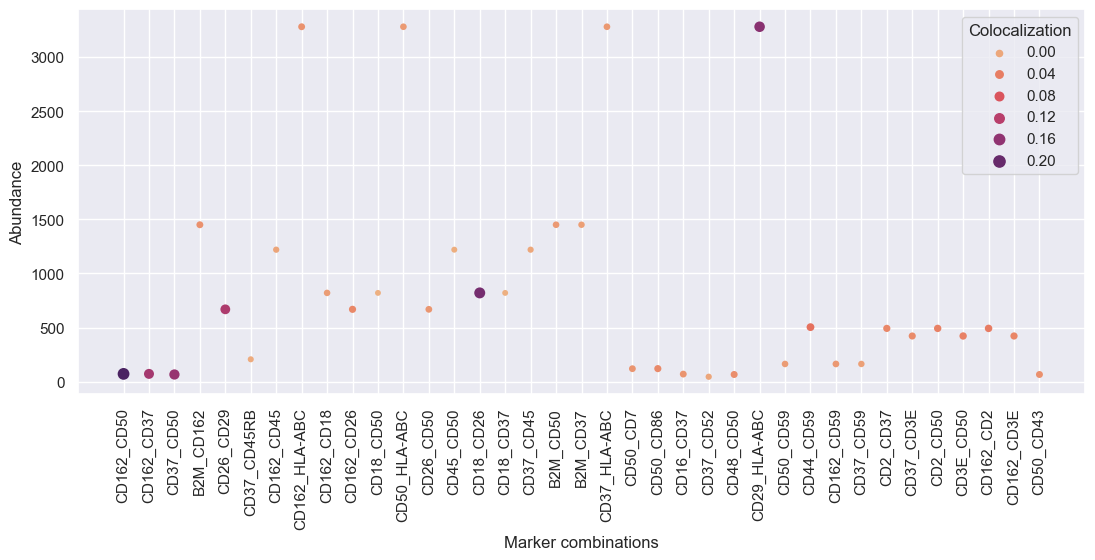

In [28]:
# merge abundance DataFrame and similarity DataFrame
abundance_vs_smlr_df = pd.DataFrame({"markers": smlr_df.index.values, "Colocalization": smlr_df.values, "Abundance": max_abundance})
abundance_vs_smlr_df = abundance_vs_smlr_df.set_index("markers")

# create a scatter plot highlithing the correlation between abundance and pairwise colocalization
sns.set(rc={'figure.figsize':(13, 5)})
sns.scatterplot(x=abundance_vs_smlr_df.index.values, y=abundance_vs_smlr_df["Abundance"], 
                hue=abundance_vs_smlr_df["Colocalization"], palette="flare", size=abundance_vs_smlr_df["Colocalization"], linewidth=0)

plt.xlabel("Marker combinations")
plt.xticks(rotation=90)
;